In [1]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

In [2]:
data = load_boston()
# 波士顿数据集非常简单，但它所涉及到的问题却很多
X = data.data
y = data.target

In [3]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X, y, test_size=0.3, random_state=420)

## 选择弱评估器：重要参数booster

In [4]:
for booster in ['gbtree', 'gblinear', 'dart']:
    reg = XGBR(n_estimators=180,
              learning_rate=0.1,
              random_state=420,
              booster=booster).fit(Xtrain, Ytrain)
    print(booster)
    print(reg.score(Xtest, Ytest))

gbtree
0.9260984298390122
gblinear
0.6472488352160215
dart
0.9260984373654245


## XGB的目标函数：重要参数objective

In [5]:
# 默认reg:linear
reg = XGBR(n_estimators=180, random_state=420).fit(Xtrain, Ytrain)
reg.score(Xtest, Ytest)

0.9050526024842831

In [6]:
MSE(Ytest, reg.predict(Xtest))

8.835224213421986

### xgb实现法

In [7]:
import xgboost as xgb

In [8]:
# 使用类DMatrix读取数据
dtrain = xgb.DMatrix(Xtrain, Ytrain)  # 特征矩阵和标签都进行一个传入
dtest = xgb.DMatrix(Xtest, Ytest)

In [9]:
# 非常遗憾无法打开来查看，所以通常都是先读到pandas里面查看之后再放到DMatrix中
dtrain

In [10]:
pd.DataFrame(Xtrain).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.03041,0.0,5.19,0.0,0.515,5.895,59.6,5.6150,5.0,224.0,20.2,394.81,10.56
1,0.04113,25.0,4.86,0.0,0.426,6.727,33.5,5.4007,4.0,281.0,19.0,396.90,5.29
2,10.23300,0.0,18.10,0.0,0.614,6.185,96.7,2.1705,24.0,666.0,20.2,379.70,18.03
3,0.17142,0.0,6.91,0.0,0.448,5.682,33.8,5.1004,3.0,233.0,17.9,396.90,10.21
4,0.05059,0.0,4.49,0.0,0.449,6.389,48.0,4.7794,3.0,247.0,18.5,396.90,9.62


In [11]:
# 写明参数
param = {# 'silent': True,  # 默认为False，通常要手动把它关闭掉, 是否打印训练记录，新版本将会取消这个参数
         # 'objective':'reg:linear',
         'objective':'reg:squarederror',
         'eta': 0.1}
num_round = 180  # n_estimators

In [12]:
# 类train，可以直接导入的参数是训练数据，树的数量，其他参数都需要通过params来导入
bst = xgb.train(param, dtrain, num_round)

In [13]:
# 接口predict
preds = bst.predict(dtest)

In [14]:
preds

array([ 6.4613175, 22.123888 , 30.755163 , 13.424351 ,  8.378565 ,
       23.608477 , 14.2151165, 16.026499 , 15.498961 , 14.10649  ,
       24.030867 , 34.36362  , 21.461111 , 28.839497 , 19.568035 ,
       10.188658 , 19.42369  , 23.539951 , 22.850523 , 23.198708 ,
       17.82486  , 16.07219  , 27.602034 , 20.773046 , 20.868807 ,
       15.865789 , 22.076588 , 29.292158 , 22.841051 , 15.770392 ,
       36.680496 , 21.057947 , 20.137005 , 23.777853 , 22.70615  ,
       23.863268 , 15.595315 , 24.565872 , 17.720552 , 33.95111  ,
       18.784286 , 20.483374 , 37.10668  , 18.068268 , 12.73839  ,
       31.186407 , 45.895035 , 12.696718 , 10.773068 , 36.064293 ,
       26.262571 , 19.908836 , 20.715096 , 48.814903 , 27.550056 ,
       25.225826 , 17.15366  , 21.215551 , 17.426773 , 18.478971 ,
       14.6453705, 22.841473 , 18.869593 , 29.990978 , 29.933191 ,
       18.756853 , 18.784918 , 16.33361  , 23.155968 , 19.144344 ,
       29.724382 , 42.121906 , 31.544363 , 23.017508 , 19.5360

In [15]:
from sklearn.metrics import r2_score
r2_score(Ytest, preds)

0.9260984298390122

In [16]:
MSE(Ytest,preds)

6.87682821415069

## 参数化决策树f<sub>k</sub>(x)，：参数alpha，lambda

In [18]:
# 使用网格搜索来查找最佳的参数组合
from sklearn.model_selection import GridSearchCV

param = {"reg_alpha": np.arange(
    0, 5, 0.05), "reg_lambda": np.arange(0, 2, 0.05)}

gscv = GridSearchCV(reg, param_grid=param,
                    scoring="neg_mean_squared_error", cv=5)

In [19]:
#======【TIME WARNING：10~20 mins】======#
time0 = time()
gscv.fit(Xtrain, Ytrain)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

15:26:927222


In [20]:
gscv.best_params_

{'reg_alpha': 4.75, 'reg_lambda': 0.6000000000000001}

In [21]:
gscv.best_score_

-13.478793667627182

In [29]:
from sklearn.metrics import r2_score, mean_squared_error as MSE
r2_score(Ytest, preds)

0.9260984298390122

In [30]:
preds = gscv.predict(Xtest)
MSE(Ytest, preds)

7.069018505694659

## 让树停止生长：重要参数gamma

In [31]:
import xgboost as xgb

# 为了便捷，使用全数据
dfull = xgb.DMatrix(X, y)

In [38]:
# 设定参数
param1 = {
#     'silent': True, 
    'objective': 'reg:squarederror', 
    "gamma": 0}
num_round = 100
n_fold = 5  # sklearn - KFold

In [39]:
# 使用类xgb.cv
time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

00:00:265130


In [40]:
# 看看类xgb.cv生成了什么结果？
cvresult1  # 随着树不断增加，我们的模型的效果如何变化

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.105578,0.129116,17.163215,0.584297
1,12.337973,0.097557,12.519735,0.473457
2,8.994071,0.065756,9.404534,0.472310
3,6.629481,0.050323,7.250335,0.500342
4,4.954406,0.033209,5.920812,0.591874
...,...,...,...,...
95,0.025204,0.005145,3.669921,0.858313
96,0.024422,0.005242,3.669984,0.858255
97,0.023661,0.005117,3.669947,0.858332
98,0.022562,0.004704,3.669868,0.858578


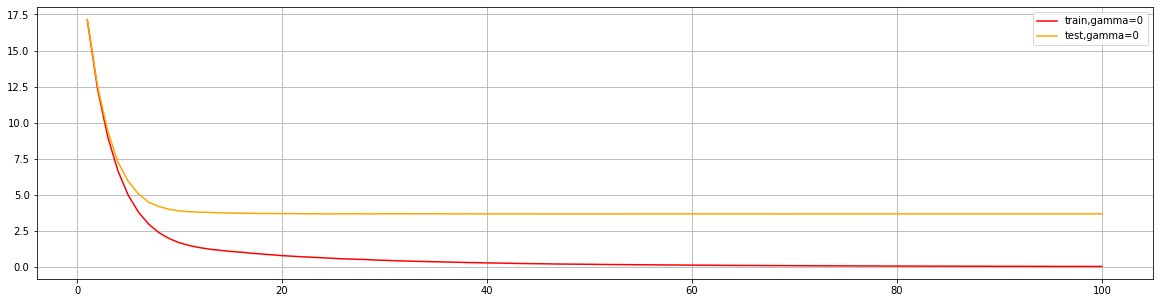

In [41]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(range(1, 101), cvresult1.iloc[:, 0], c="red", label="train,gamma=0")
plt.plot(range(1, 101), cvresult1.iloc[:, 2], c="orange", label="test,gamma=0")
plt.legend()
plt.show()

# 从这个图中，我们可以看出什么？
# 怎样从图中观察模型的泛化能力？
# 从这个图的角度来说，模型的调参目标是什么？

In [42]:
# xgboost中回归模型的默认模型评估指标是什么？R^2

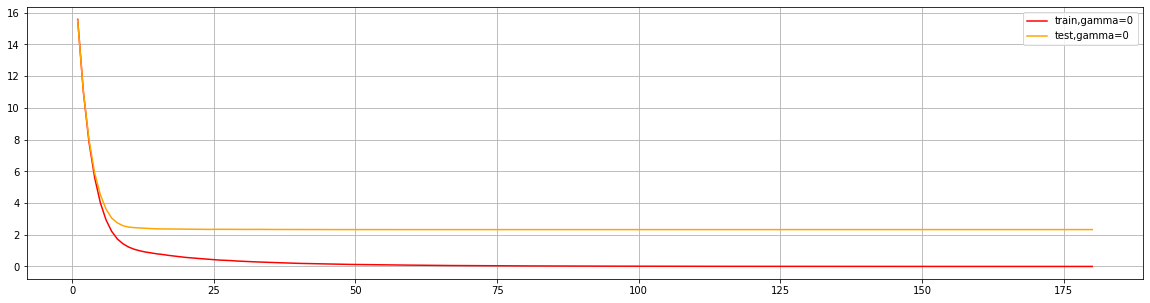

In [47]:
param1 = {
    # 'silent':True,
    'objective': 'reg:squarederror',
    "gamma": 0,
    "eval_metric": "mae"}

cvresult1 = xgb.cv(param1, dfull, 180, n_fold)

plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(range(1, 181), cvresult1.iloc[:, 0], c="red", label="train,gamma=0")
plt.plot(range(1, 181), cvresult1.iloc[:, 2], c="orange", label="test,gamma=0")
plt.legend()
plt.show()

In [52]:
param1 = {'objective': 'reg:squarederror', "gamma": 0}
param2 = {'objective': 'reg:squarederror', "gamma": 20}
num_round = 180
n_fold = 5

time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

00:00:589758


In [53]:
time0 = time()
cvresult2 = xgb.cv(param2, dfull, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

00:00:682132


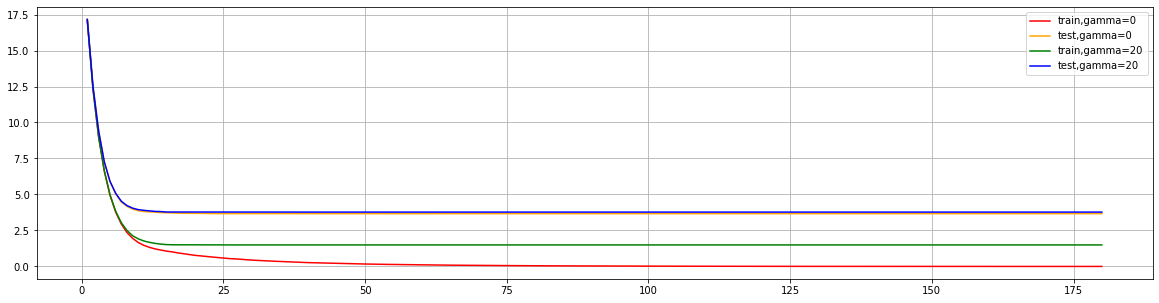

In [54]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(range(1, 181), cvresult1.iloc[:, 0], c="red", label="train,gamma=0")
plt.plot(range(1, 181), cvresult1.iloc[:, 2], c="orange", label="test,gamma=0")
plt.plot(range(1, 181), cvresult2.iloc[:, 0],
         c="green", label="train,gamma=20")
plt.plot(range(1, 181), cvresult2.iloc[:, 2], c="blue", label="test,gamma=20")
plt.legend()
plt.show()

# 从这里，你看出gamma是如何控制过拟合了吗？控制训练集上的训练 - 降低训练集上的表现

In [55]:
import xgboost as xgb
import matplotlib.pyplot as plt
from time import time
import datetime

In [66]:
from sklearn.datasets import load_breast_cancer
data2 = load_breast_cancer()

x2 = data2.data
y2 = data2.target

dfull2 = xgb.DMatrix(x2, y2)

param1 = {'objective': 'binary:logistic', 'gamma': 0, 'eval_metric': 'error'}
param2 = {'objective': 'binary:logistic', "gamma": 1}
num_round = 100

In [67]:
time0 = time()
cvresult1 = xgb.cv(param1, dfull2, num_round, nfold=5, metrics=('error'))
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

00:00:296612


In [69]:
time0 = time()
cvresult2 = xgb.cv(param2, dfull2, num_round, nfold=5, metrics=("error"))
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

00:00:545407


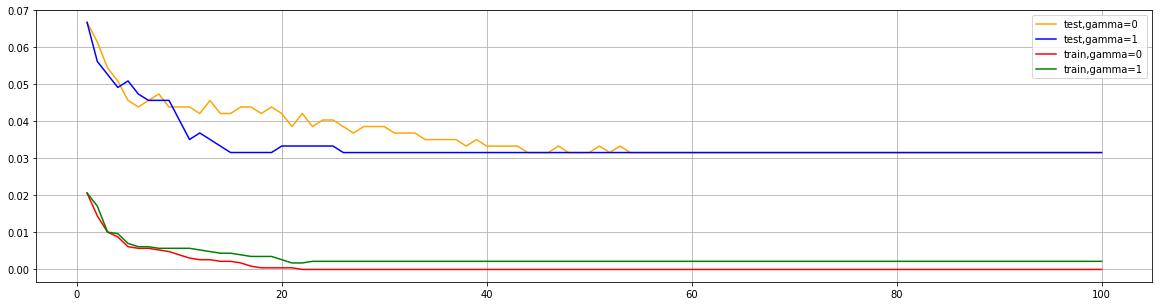

In [72]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(range(1, 101), cvresult1.iloc[:, 2], c="orange", label="test,gamma=0")
plt.plot(range(1, 101), cvresult2.iloc[:, 2], c="blue", label="test,gamma=1")
plt.plot(range(1, 101), cvresult1.iloc[:, 0], c="red", label="train,gamma=0")
plt.plot(range(1, 101), cvresult2.iloc[:, 0], c="green", label="train,gamma=1")
plt.legend()
plt.show()